# Краткое описание датасета
датасет представляет собой набор данных о работниках некоторой компании.

датасет взят из https://www.kaggle.com/datasets/dev0914sharma/customer-clustering

### Атрибуты

 *   ID - уникальный номер работника
 *   Sex - пол
 *   Marital status - семейное положение
 *   Age - возраст
 *   Education - полученное образование
 *   Income - доход
 *   Occupation - профессия
 *   Settlement size - размер населенного пункта, где проживает работник

 В данном датасете категориальные переменные сразу закодированы целочисленными значениями.

# Первичная обработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('segmentation data.csv')
df.head()


,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


Для послдующего анализа нет необходимости в ID работникаб, профессия, тк оно не нужен в задаче кластеризации.


In [3]:
df = df.drop(columns=['ID'])
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB


In [5]:
df.isnull().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [6]:
df.nunique()

Sex                   2
Marital status        2
Age                  58
Education             4
Income             1982
Occupation            3
Settlement size       3
dtype: int64

In [7]:
df.shape, df.drop_duplicates().shape

((2000, 7), (2000, 7))

Дубликаты и пустые значения отсутствуют

Для поиска выбросов воспользуемся Z-score

In [8]:
from scipy import stats
import numpy as np

df.info()
for attr in df:
    attr_zscore = np.abs(stats.zscore(df[attr]))
    df[attr] = df[attr][attr_zscore<3]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex              2000 non-null   int64  
 1   Marital status   2000 non-null   int64  
 2   Age              1989 non-null   float64
 3   Education        1964 non-null   float64
 4   Income           1969 non-null   float64
 5   Occupation       2000 non

In [9]:
df = df.dropna()

### Добавление дополнительной переменной

Будет добавлена категориальная переменная Income_status, обозначающая категорию заработка. Имеет три значения: 0, 1, 2. 0 - низкий заработок, 1 - средний заработок, 2 - высокий заработок.

In [10]:
def income_status(x):
    if x <= 60_000:
        return 0  # Low income
    elif 60_000 < x <= 150_000:
        return 1  # Average income
    elif x > 150_000:
        return 2  # High income

df['Income_status'] = df['Income'].apply(income_status)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Income_status
0,0,0,67.0,2.0,124670.0,1,2,1
1,1,1,22.0,1.0,150773.0,1,2,2
2,0,0,49.0,1.0,89210.0,0,0,1
3,0,0,45.0,1.0,171565.0,1,1,2
4,0,0,53.0,1.0,149031.0,1,1,1


# Отношение количественных переменных друг к другу


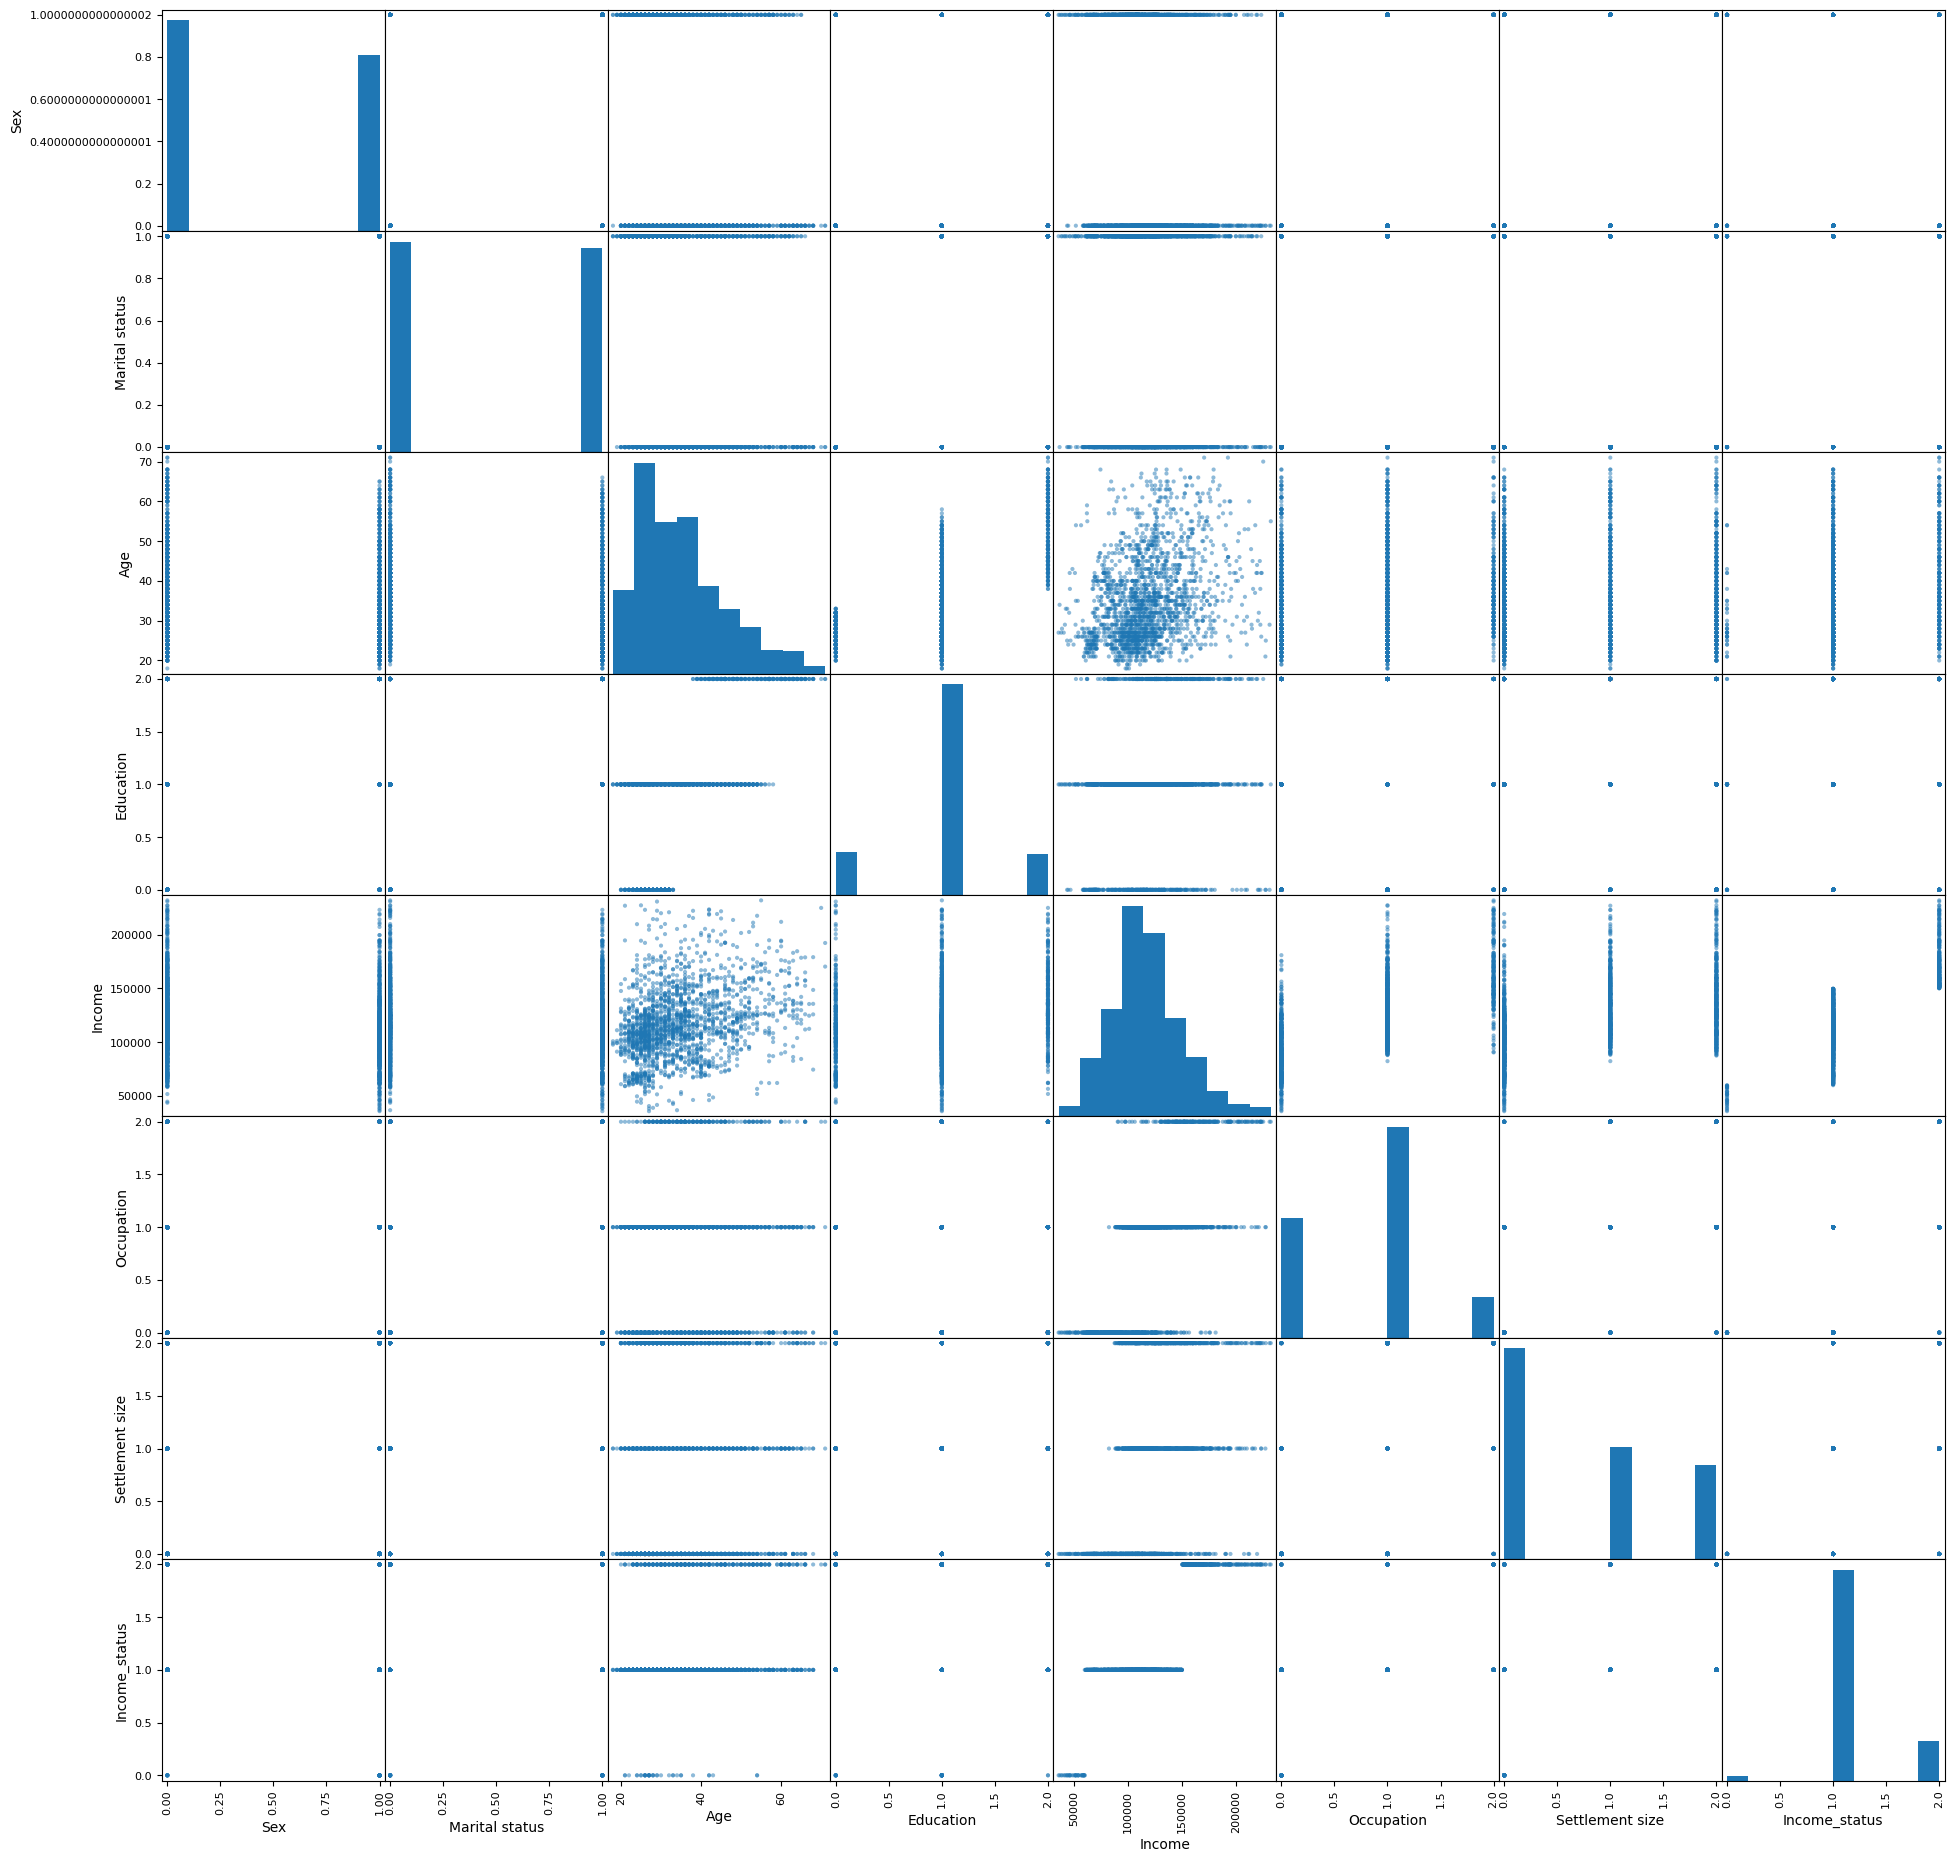

In [11]:
scatter = pd.plotting.scatter_matrix(
    df,
    figsize=(23, 23)
)

Наиболее четкие кластера можно увидеть по строке Income и строке Age. В целом практически для всех пар видна более менее четкая кластеризация. За исключением пары Income - Age
Например, для пары age и education видно, что, чем старше человек, чем выше его уровень образования. 
Для пары occupation и Income наблюдается разделение дохода по профессиям, что в целом логично. 
Также стоит отметить, что для строки Income_status - созданной искусственно также видна четка кластеризация, что означает правильность заданной функции для расчета доп. переменной. 

# Подготовка данных для обучения модели

In [12]:
X = df

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [13]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.924528,1.0,0.452885,0.5,1.0,0.5
1,1.0,1.0,0.075472,0.5,0.585955,0.5,1.0,1.0
2,0.0,0.0,0.584906,0.5,0.272115,0.0,0.0,0.5
3,0.0,0.0,0.509434,0.5,0.691950,0.5,0.5,1.0
4,0.0,0.0,0.660377,0.5,0.577075,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...
1921,1.0,0.0,0.547170,0.5,0.447048,0.0,0.0,0.5
1922,1.0,1.0,0.169811,0.5,0.417577,0.5,0.0,0.5
1923,0.0,0.0,0.245283,0.0,0.257790,0.0,0.0,0.5
1924,1.0,1.0,0.113208,0.5,0.316762,0.0,0.0,0.5


# Обучение модели

In [14]:
models = [KMeans(n_clusters=n).fit(X) for n in range(2, 11)]
scores = pd.DataFrame(columns=['n_clusters', 'inertia', 'silhoette_score'])

for n in range(2, 11):
    print(f'KMeans with {n} clusters:')
    model = KMeans(n_clusters=n)
    model.fit(X)
    print(f'Inertia: {model.inertia_}')
    print(f'Silhouette score: {silhouette_score(X, model.labels_)}')
    print('\n')
    scores.loc[len(scores)] = [n, model.inertia_, silhouette_score(X, model.labels_)]

KMeans with 2 clusters:
Inertia: 1123.1813784022586
Silhouette score: 0.3603912616118918


KMeans with 3 clusters:
Inertia: 930.8515405958486
Silhouette score: 0.3120559600835827


KMeans with 4 clusters:
Inertia: 726.4120809261666
Silhouette score: 0.3663397976792442


KMeans with 5 clusters:
Inertia: 640.1956670596019
Silhouette score: 0.3250759904255441


KMeans with 6 clusters:
Inertia: 510.1086264306781
Silhouette score: 0.38701553355979795


KMeans with 7 clusters:
Inertia: 478.91605058793056
Silhouette score: 0.3534166569399206


KMeans with 8 clusters:
Inertia: 445.043113776146
Silhouette score: 0.36144790104087077


KMeans with 9 clusters:
Inertia: 405.54129990159163
Silhouette score: 0.3697714928572068


KMeans with 10 clusters:
Inertia: 394.201407577999
Silhouette score: 0.3597825410131929




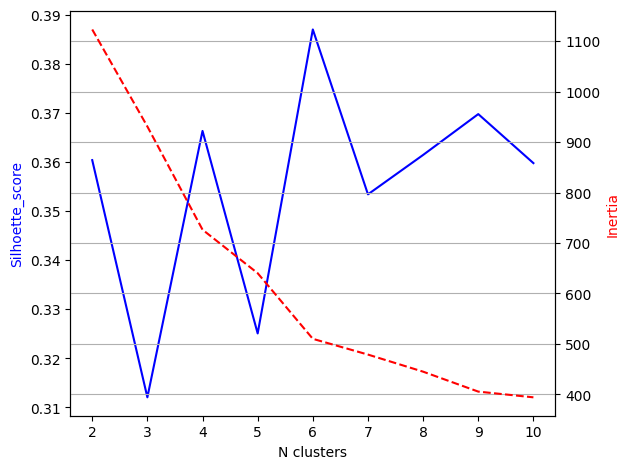

In [15]:
fig, ax1 = plt.subplots()

ax1.plot(scores['n_clusters'], scores['silhoette_score'], 'b-', label='Silhoette score')
ax1.set_xlabel('N clusters')
ax1.set_ylabel('Silhoette_score', color='b')

ax2 = ax1.twinx()
ax2.plot(scores['n_clusters'], scores['inertia'], 'r--', label='Inertia')
ax2.set_ylabel('Inertia', color='r')

fig.tight_layout()
plt.grid()
plt.show()


Как показыет практика, лучше всего использовать число кластеров, при котором высокая силуэтная оценка и наблюдается снижение инерции. 
По данному графику 6 кластеров даст хорошее отношение сегментацией  и приемлемой инерцией.



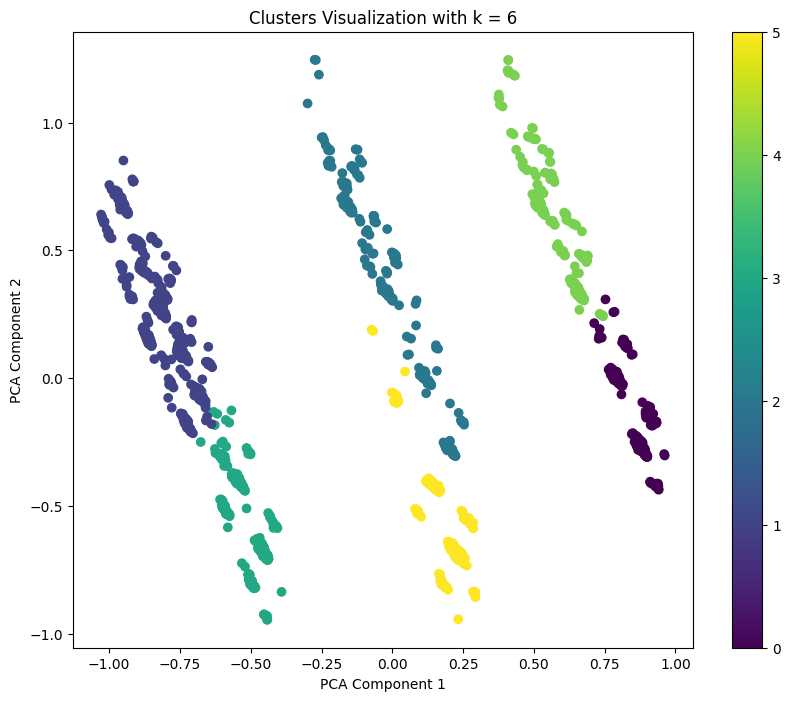

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

optimal_k = 6
model = KMeans(n_clusters=optimal_k)
clusters = model.fit_predict(X)


pca = PCA(2)
scatter_plot_points = pca.fit_transform(X)


plt.figure(figsize=(10, 8))
plt.scatter(scatter_plot_points[:, 0], scatter_plot_points[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title(f'Clusters Visualization with k = {optimal_k}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Вывод

В ходе выполнения данной работы, мы провели анализ кластеризации для датасета, а также поптылаись применить метод Kmeans, оценив оптимальное число кластеров. Затем мы визуализировали кластера с ипользованием метода главных компонент и получили четко выраженные кластера. 
Анализ полученных кластеров:
5й кластер:
Предположу, что включает в себя молодых людей с некоторым уровнем образования, но варирующимся доходом - такой вывоод хорошо просматривается по графикам рассеивания. 
2й кластер в таком случае выделяет более взрослых людей с более высоким доходом и очевидно высоким уровнем образования. 
Аналогичные суждения можно привести для оставшихся класетров, которые могу быть разделены, например, по размеру поселения. 